#Stratégie adoptée

Obtenir des prédictions satisfaisantes avec ce dataset relève du défi. Si nous disposions d'une ferme de serveurs, nous pourrions utiliser RFECV pour sélectionner automatiquement les meilleures features. A défaut, nous allons tenter une stratégie moins gourmande :

1. Features importance

XGBoostRegressor va fournir une liste de features par ordre décroissant.



2. Forward selection

L'algorithme sera plus économe en ressources que RFECV parce qu'on intègrera au fur et à mesure les features les plus importantes, jusqu'à ce que le score n'augmente plus.

#1.Installation de scikit-optimize

Cette librairie, créée par les développeurs de scikit-learn, nous permettra d'obtenir plus rapidement les meilleurs hyperparamètres.

https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.1 MB/s eta 0:00:00


#2.Chargement des librairies

In [ ]:
# System
import os
from joblib import dump, load
from google.colab import files
import warnings

# Data
import pandas as pd
import numpy as np
import math
from scipy.stats import randint, uniform, loguniform
from scipy.sparse import issparse
from sklearn.utils import shuffle

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning - Preprocessing
import sklearn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, PowerTransformer, FunctionTransformer, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

# Machine learning - Automatisation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
from sklearn.dummy import DummyRegressor

# Machine learning - Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer, PredictionErrorDisplay

# Machine learning - Models
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, VotingRegressor, IsolationForest
from sklearn.multioutput import RegressorChain
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import LocalOutlierFactor

# Machine learning - Model selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit, HalvingRandomSearchCV, cross_val_score, learning_curve
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.exceptions import NotFittedError

#3.Configuration

XGBoost utilise une méthode de sampling plus performante avec une carte graphique, donc il est préférable d'utiliser le GPU Runtime de Google Colab. Si ce n'est pas possible, alors la section 8.2.1 doit être remplacée par la version CPU (8.2.2).

In [ ]:
# Silence warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount GoogleDrive and set the files path
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CO2'

Mounted at /content/drive
/content/drive/MyDrive/CO2


#3.Chargement du dataset

In [ ]:
df = pd.read_csv('co2_predictions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   primarypropertytype        3189 non-null   object 
 1   councildistrictcode        3189 non-null   int64  
 2   numberofbuildings          3189 non-null   int64  
 3   numberoffloors             3189 non-null   int64  
 4   propertygfatotal           3189 non-null   int64  
 5   propertygfaparking         3189 non-null   int64  
 6   listofallpropertyusetypes  3189 non-null   object 
 7   largestpropertyusetype     3178 non-null   object 
 8   energystarscore            2386 non-null   float64
 9   siteeuiwn_kbtu_sf          3189 non-null   float64
 10  sourceeuiwn_kbtu_sf        3189 non-null   float64
 11  siteenergyuse_kbtu         3189 non-null   float64
 12  siteenergyusewn_kbtu       3189 non-null   float64
 13  steam                      3189 non-null   objec

In [ ]:
# Fix dtype changes after CSV exporting
df['energystarscore'] = df['energystarscore'].astype('object')
df['councildistrictcode'] = df['councildistrictcode'].astype('object')
# Turn the boolean columns into categorical for target encoding
# for column in df.select_dtypes(include=['bool']).columns:
#   df[column] = df[column].astype('object')
df.dtypes

primarypropertytype           object
councildistrictcode           object
numberofbuildings              int64
numberoffloors                 int64
propertygfatotal               int64
propertygfaparking             int64
listofallpropertyusetypes     object
largestpropertyusetype        object
energystarscore               object
siteeuiwn_kbtu_sf            float64
sourceeuiwn_kbtu_sf          float64
siteenergyuse_kbtu           float64
siteenergyusewn_kbtu         float64
steam                         object
naturalgas                    object
totalghgemissions            float64
age                            int64
source_site                  float64
source_wn                    float64
site_wn                      float64
dtype: object

Après avoir tenté toutes sortes d'options pour imputer les données manquantes (SimpleImputer, KNN, native XGBoost...), la méthode la plus simple s'avère la plus efficace :

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2379 entries, 0 to 3174
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   primarypropertytype        2379 non-null   object 
 1   councildistrictcode        2379 non-null   object 
 2   numberofbuildings          2379 non-null   int64  
 3   numberoffloors             2379 non-null   int64  
 4   propertygfatotal           2379 non-null   int64  
 5   propertygfaparking         2379 non-null   int64  
 6   listofallpropertyusetypes  2379 non-null   object 
 7   largestpropertyusetype     2379 non-null   object 
 8   energystarscore            2379 non-null   object 
 9   siteeuiwn_kbtu_sf          2379 non-null   float64
 10  sourceeuiwn_kbtu_sf        2379 non-null   float64
 11  siteenergyuse_kbtu         2379 non-null   float64
 12  siteenergyusewn_kbtu       2379 non-null   float64
 13  steam                      2379 non-null   objec

#4.Gestion des targets multiples

In [ ]:
# Define the targets and features
targets = ['sourceeuiwn_kbtu_sf', 'source_wn', 'siteeuiwn_kbtu_sf', 'site_wn', 'source_site', 'siteenergyusewn_kbtu', 'siteenergyuse_kbtu', 'totalghgemissions']
y = df[targets]
X = df.drop(targets, axis=1)

In [ ]:
X.select_dtypes(include=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2379 entries, 0 to 3174
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   numberofbuildings   2379 non-null   int64
 1   numberoffloors      2379 non-null   int64
 2   propertygfatotal    2379 non-null   int64
 3   propertygfaparking  2379 non-null   int64
 4   age                 2379 non-null   int64
dtypes: int64(5)
memory usage: 111.5 KB


In [ ]:
X.select_dtypes(include=['object', 'bool']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2379 entries, 0 to 3174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   primarypropertytype        2379 non-null   object
 1   councildistrictcode        2379 non-null   object
 2   listofallpropertyusetypes  2379 non-null   object
 3   largestpropertyusetype     2379 non-null   object
 4   energystarscore            2379 non-null   object
 5   steam                      2379 non-null   object
 6   naturalgas                 2379 non-null   object
dtypes: object(7)
memory usage: 148.7+ KB


#5.Preprocessing des données

Là aussi, la solution la plus simple donne les meilleurs résultats.
Pour la feature le CountVectorizer fait moins bien que OneHotEncoder.

Dans l'idéal, le count encoding, target encoding ou GLMM encoding devraient donner de meilleurs résultats, mais aucun test ne s'est révélé probant (cf. dossier predictions/tests). Quand les variables catégoriques n'ont pas la distribution adéquate, ces encodeurs ont tendance à créer des valeurs manquantes qui nuisent à la modélisation. Ou alors, ils peuvent provoquer une énorme fausse joie si le X test se retrouve contaminé par les données à prédire;)

Il nous faudrait une formation poussée en statistiques pour apprendre à regrouper les catégories sans tâtonner pendant des heures...

L'EDA a montré que certaines variables étaient loin d'avoir une distribution gaussienne. Pour y remédier, le QuantileTransformer semble préférable au PowerTransformer parce qu'il est efficace quelle que soit la distribution de départ : https://scikit-learn.org/stable/modules/preprocessing.html#mapping-to-a-gaussian-distribution

##5.3Numerical Features

La variable 'propertygfaparking' a l'air d'avoir une distribution plus gaussienne avec du Log preprocessing, mais même après avoir standardisé le résultat, les scores sont moins bons (dossier tests).

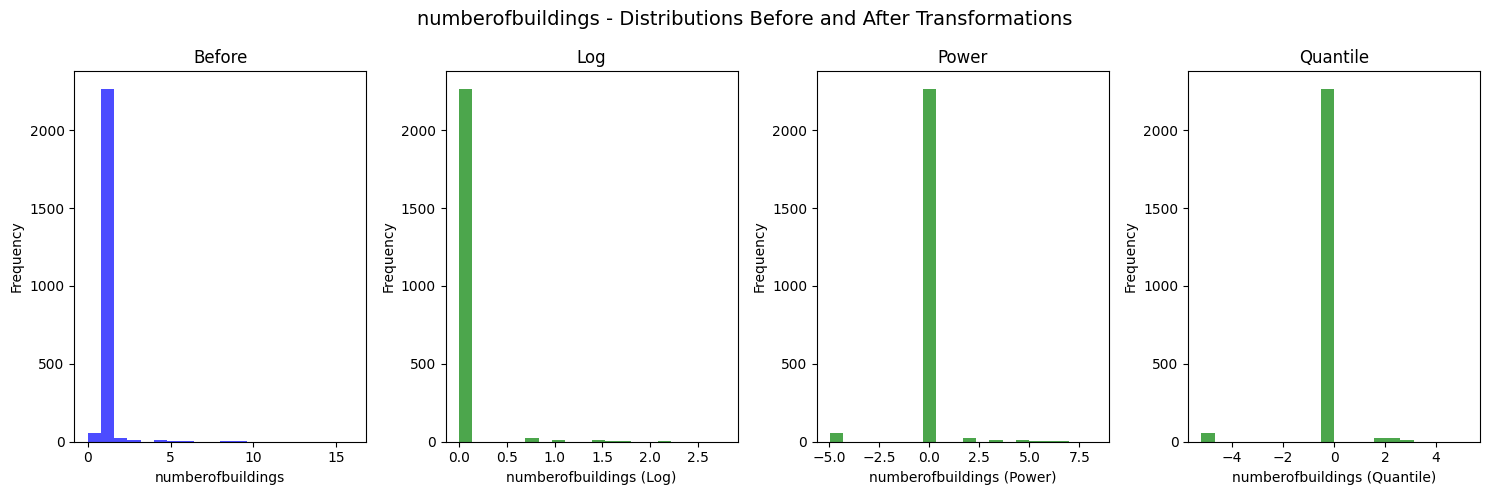

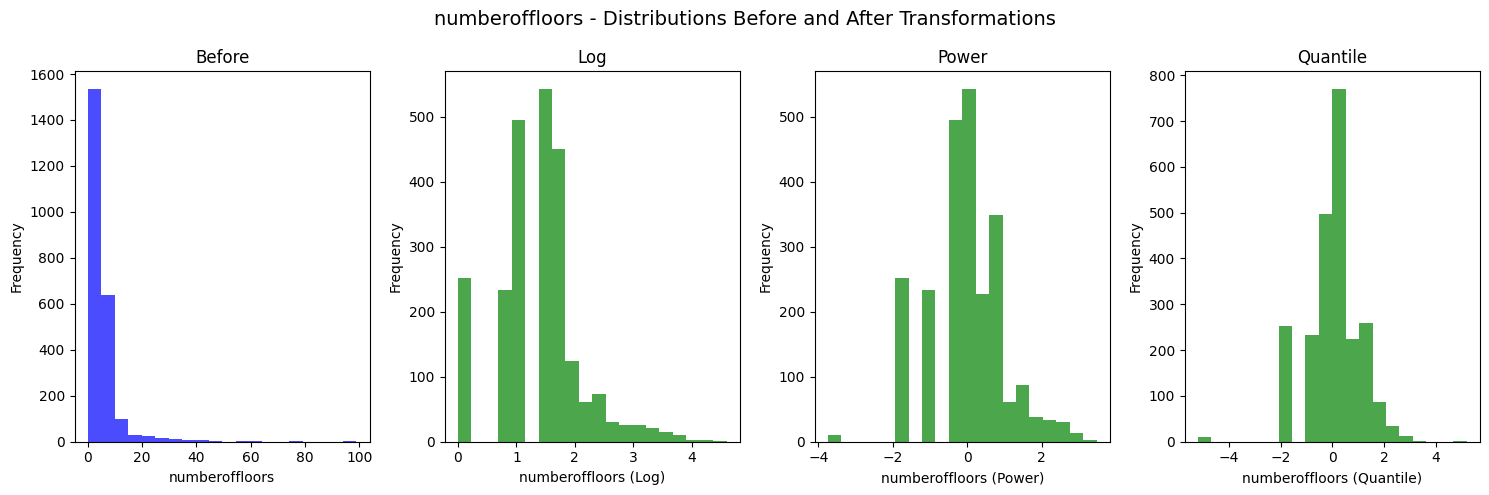

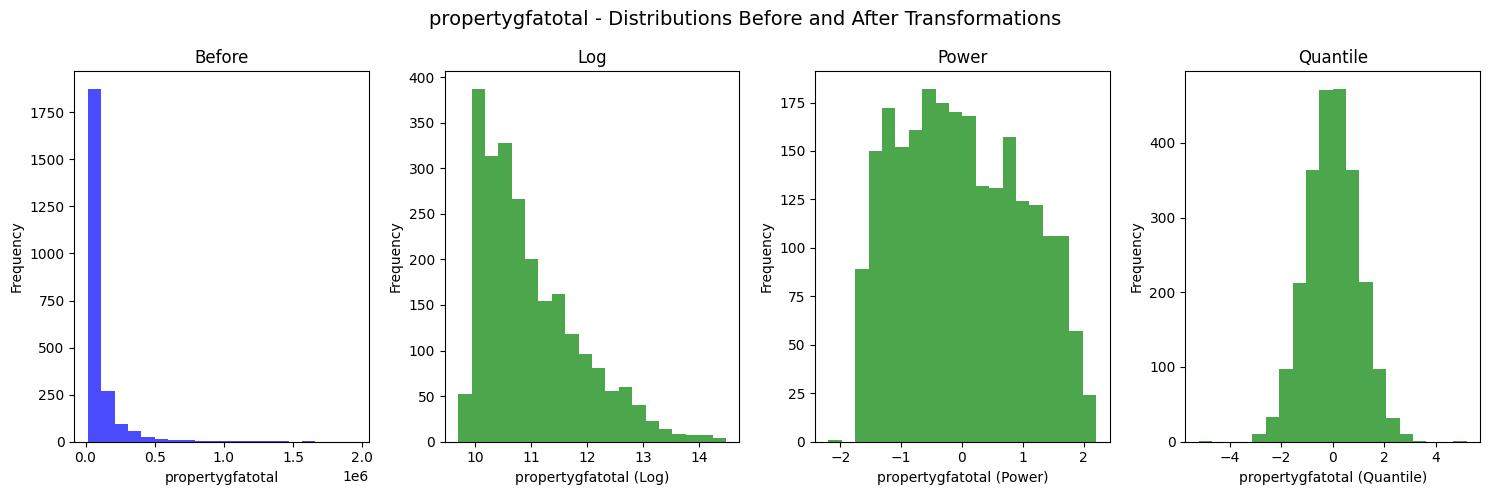

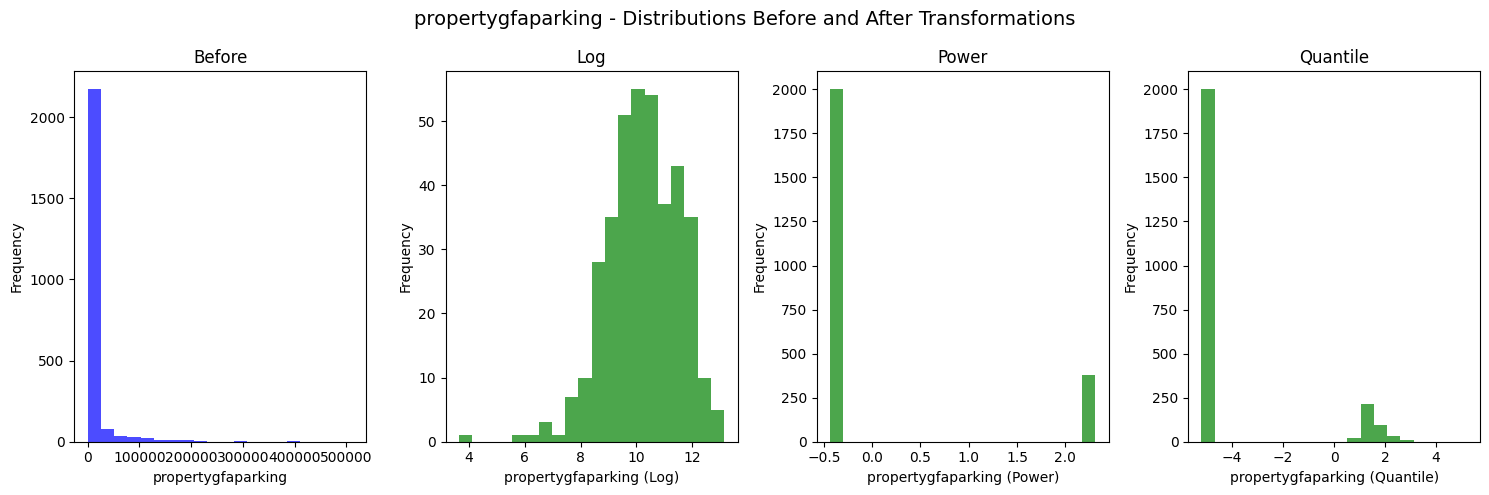

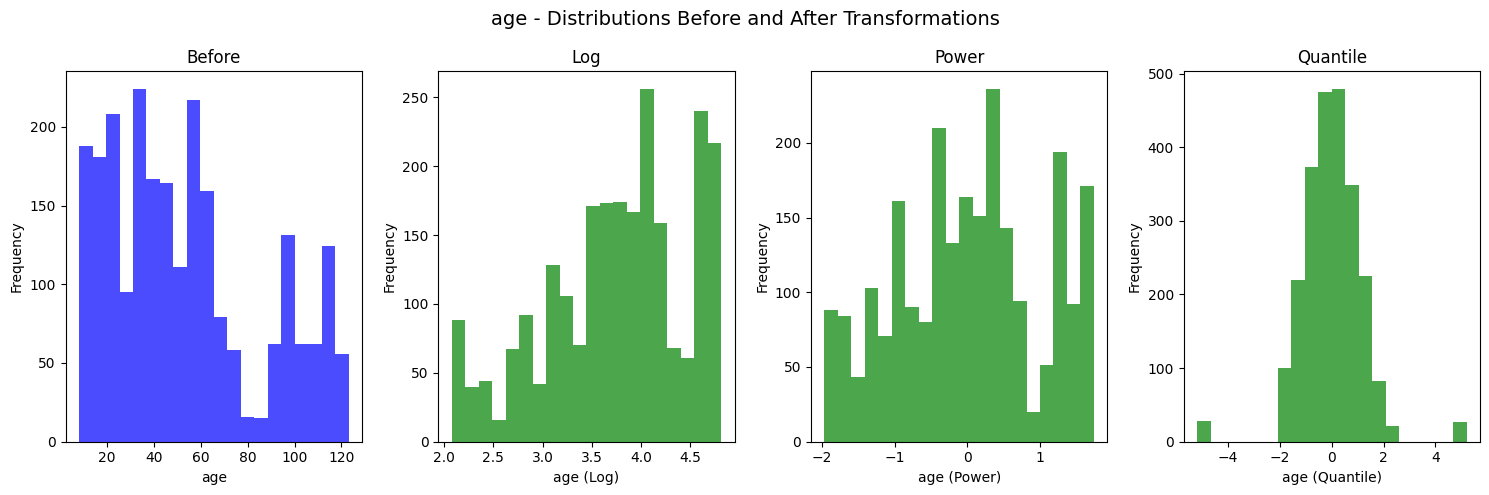

In [ ]:
# Define the transformations to apply
transformations = [('Log', np.log), ('Power', PowerTransformer()), ('Quantile', QuantileTransformer(output_distribution='normal', random_state=42))]

# Loop through the dataframe and transformations
for column in X.select_dtypes(include=['int64', 'float64']).columns:
    variable = X.select_dtypes(include=['int64', 'float64'])[column]

    # Create subplots
    fig, axes = plt.subplots(1, len(transformations) + 1, figsize=(15, 5))
    fig.suptitle(f'{column} - Distributions Before and After Transformations', fontsize=14)

    # Plot the distribution before the transformation
    axes[0].hist(variable, bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Before')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # Apply and plot each transformation
    for i, (trans_name, trans_func) in enumerate(transformations, start=1):
        if isinstance(trans_func, PowerTransformer):
            transformer = trans_func.fit(variable.values.reshape(-1, 1))
            transformed_target = transformer.transform(variable.values.reshape(-1, 1))
        elif isinstance(trans_func, QuantileTransformer):
            transformer = trans_func.fit(variable.values.reshape(-1, 1))
            transformed_target = transformer.transform(variable.values.reshape(-1, 1))
        else:
            transformed_target = trans_func(variable.values.reshape(-1, 1))

        finite_transformed_target = transformed_target[np.isfinite(transformed_target)]
        axes[i].hist(finite_transformed_target, bins=20, alpha=0.7, color='green')
        axes[i].set_title(trans_name)
        axes[i].set_xlabel(f'{column} ({trans_name})')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [ ]:
# Preprocess the numerical features
transfo_num = Pipeline(steps=[
    ('scaling', PowerTransformer()),
    # ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
    # ('data_info', data_info_transformer)
])

##5.4CountVectorizer

In [ ]:
df['listofallpropertyusetypes'].value_counts()

Multifamily Housing                                          772
Multifamily Housing, Parking                                 426
Office                                                       129
Office, Parking                                              110
Non-Refrigerated Warehouse                                    94
                                                            ... 
Food Service, Office, Parking, Restaurant                      1
Distribution Center, Office, Parking                           1
Medical Office, Other, Parking                                 1
Multifamily Housing, Other - Lodging/Residential, Parking      1
Multifamily Housing, Other - Public Services, Parking          1
Name: listofallpropertyusetypes, Length: 212, dtype: int64

Pour faciliter la modélisation, un CountVectorizer va tokeniser chaque type d'usage en utilisant le séparateur ', ' :

In [ ]:
# Fix for PicklingError when trying to dump an object that contains a lambda function
def tok(x):
  return x.split(', ')

# Fix for AttributeError: 'numpy.ndarray' object has no attribute 'lower'
class ArrayToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = X.ravel().astype(str)
        return X

# Add the ArrayToStringTransformer before the CountVectorizer (imputation shouldn't be necessary, but there's a strange bug without it...)
transfo_vec = Pipeline(steps=[
    ('imputation1', SimpleImputer(strategy='most_frequent')),
    ('converter', ArrayToStringTransformer()),
    ('vectorizer', CountVectorizer(tokenizer=tok)),
    # ('imputation2', SimpleImputer(strategy='most_frequent')),
    # ('data_info', data_info_transformer),
])

##5.5OrdinalEncoder

In [ ]:
# Preprocess with OrdinalEncoder
transfo_ord = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('scaling', PowerTransformer()),
    # ('data_info', data_info_transformer),
])

##5.6OneHotEncoder

In [ ]:
# Preprocess with CountEncoder
transfo_one = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)),
    # ('data_info', data_info_transformer),
])

Les CountVectorizer et OneHotEncoder vont démultiplier le nombre de colonnes. Pour pouvoir calculer l'importance des features, il est plus simple de regrouper les colonnes par type de processing :

In [ ]:
X = X[['numberofbuildings', 'numberoffloors', 'propertygfatotal', 'propertygfaparking', 'age',
'listofallpropertyusetypes',
'energystarscore',
'primarypropertytype', 'councildistrictcode', 'largestpropertyusetype', 'steam', 'naturalgas']]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2379 entries, 0 to 3174
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   numberofbuildings          2379 non-null   int64 
 1   numberoffloors             2379 non-null   int64 
 2   propertygfatotal           2379 non-null   int64 
 3   propertygfaparking         2379 non-null   int64 
 4   age                        2379 non-null   int64 
 5   listofallpropertyusetypes  2379 non-null   object
 6   energystarscore            2379 non-null   object
 7   primarypropertytype        2379 non-null   object
 8   councildistrictcode        2379 non-null   object
 9   largestpropertyusetype     2379 non-null   object
 10  steam                      2379 non-null   object
 11  naturalgas                 2379 non-null   object
dtypes: int64(5), object(7)
memory usage: 241.6+ KB


##5.1Targets

Dans la section 8.2, TransformedTargetRegressor va nous permettre d'effectuer le y scaling sans avoir à écrire de fonction, mais il reste à déterminer ce qui conviendrait le mieux. Le QuantileTransformer est celui qui parvient le mieux à rééquilibrer les distributions pour les rendre véritablement gaussiennes. Mais il le fait au prix

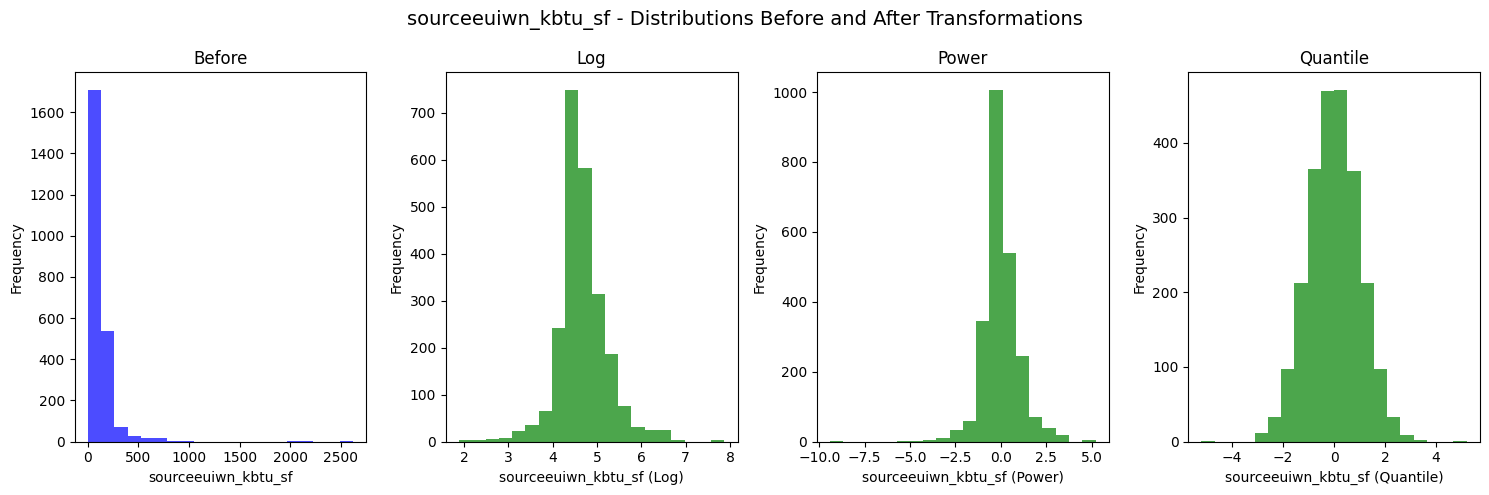

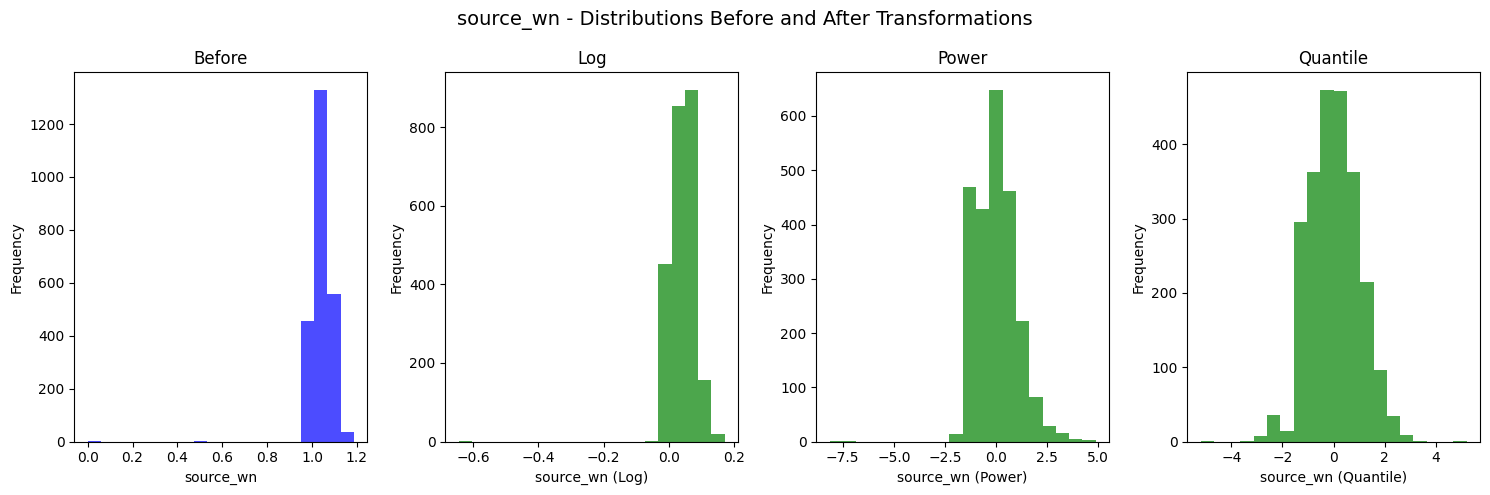

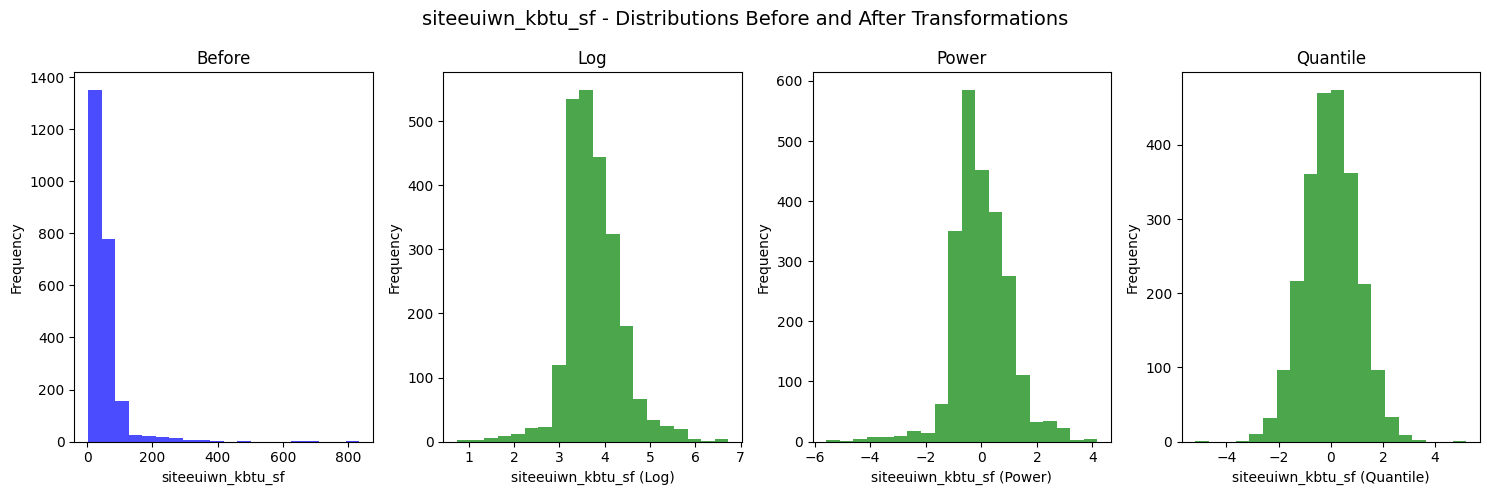

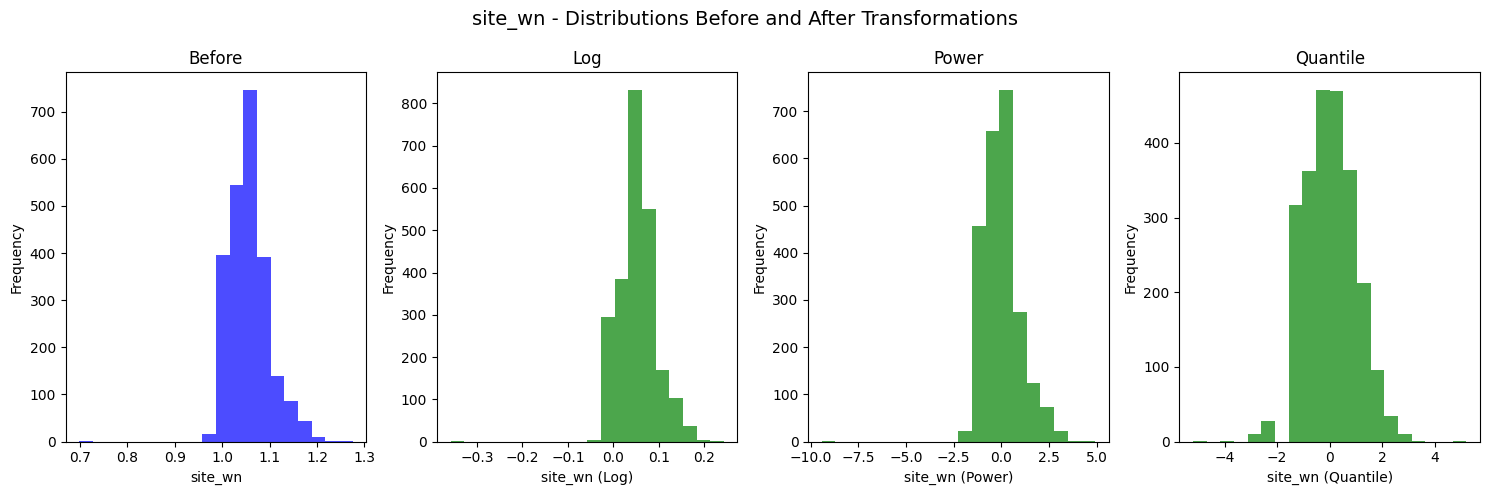

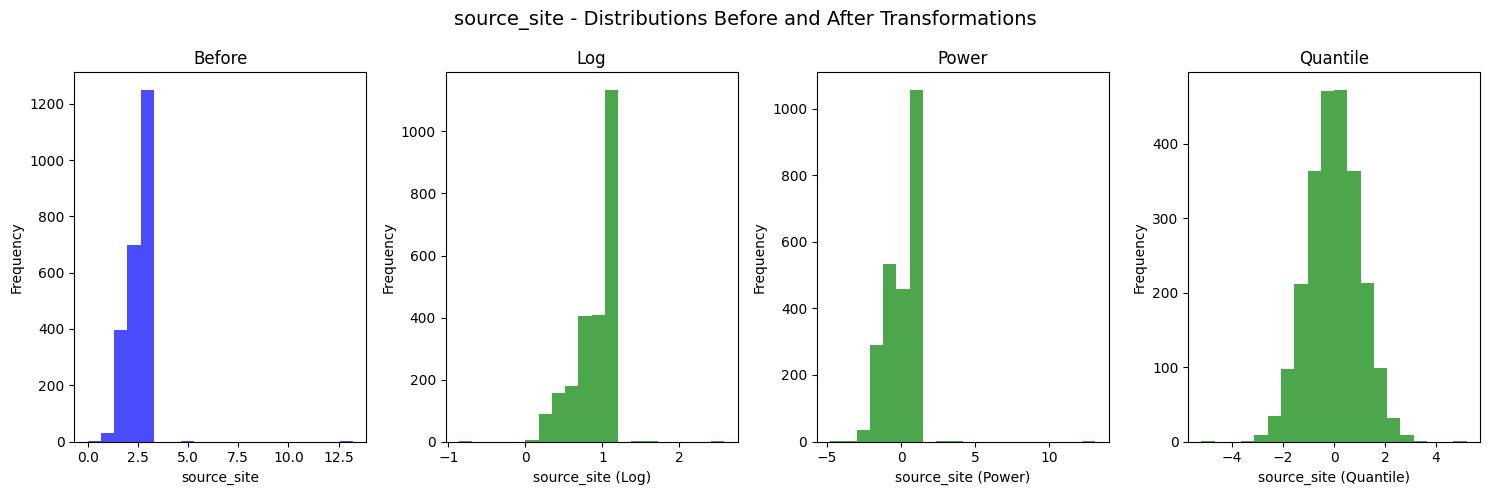

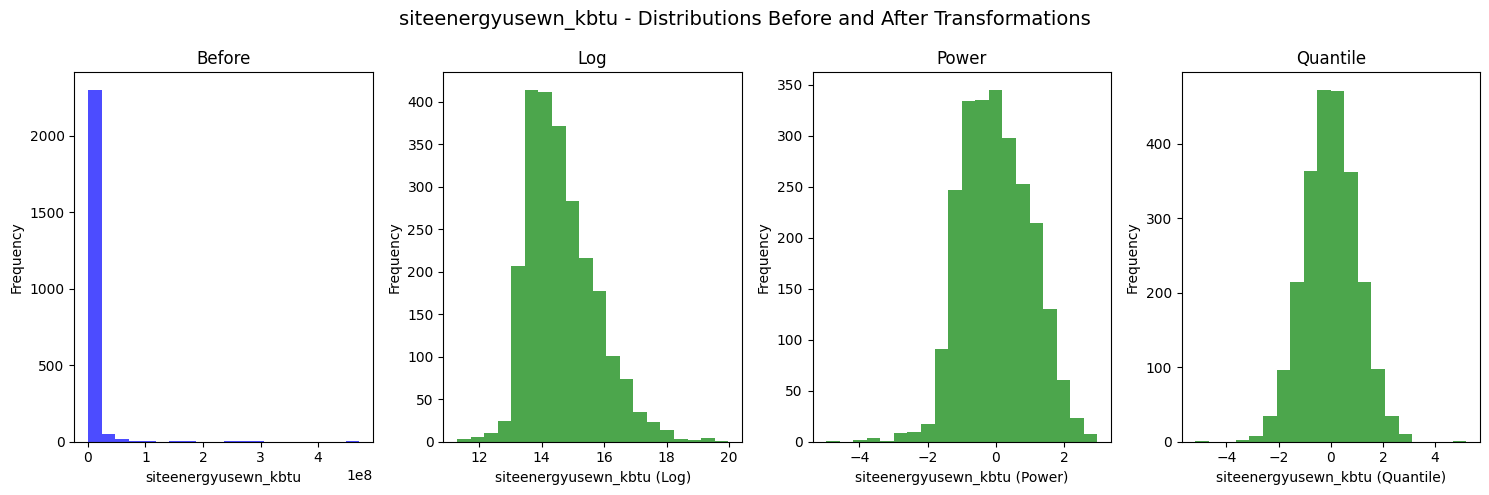

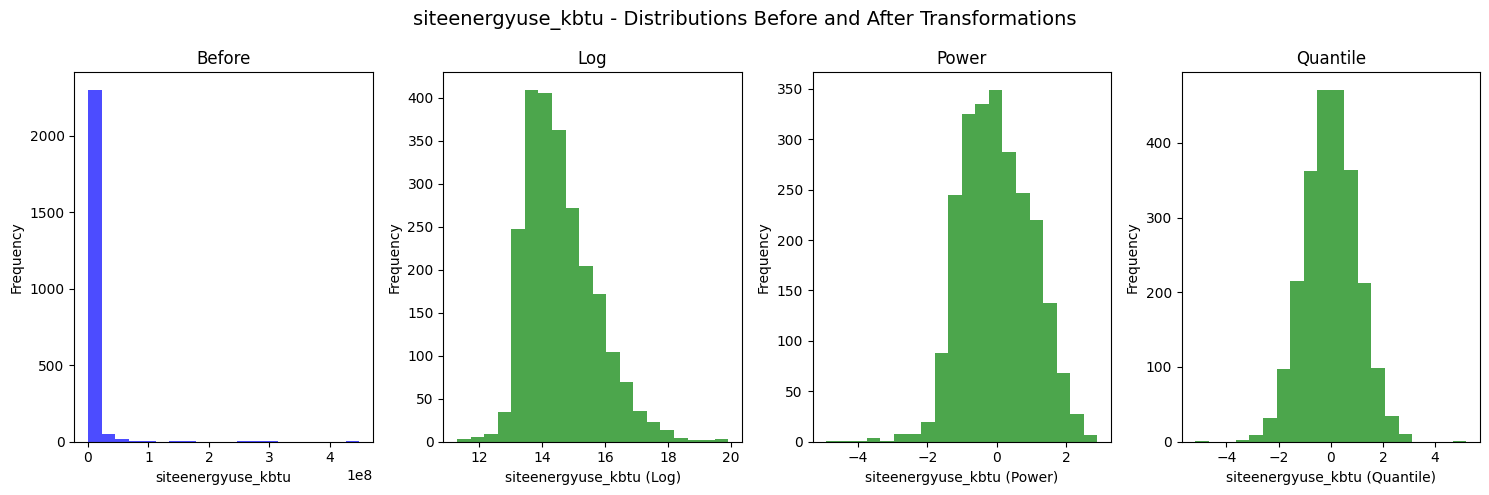

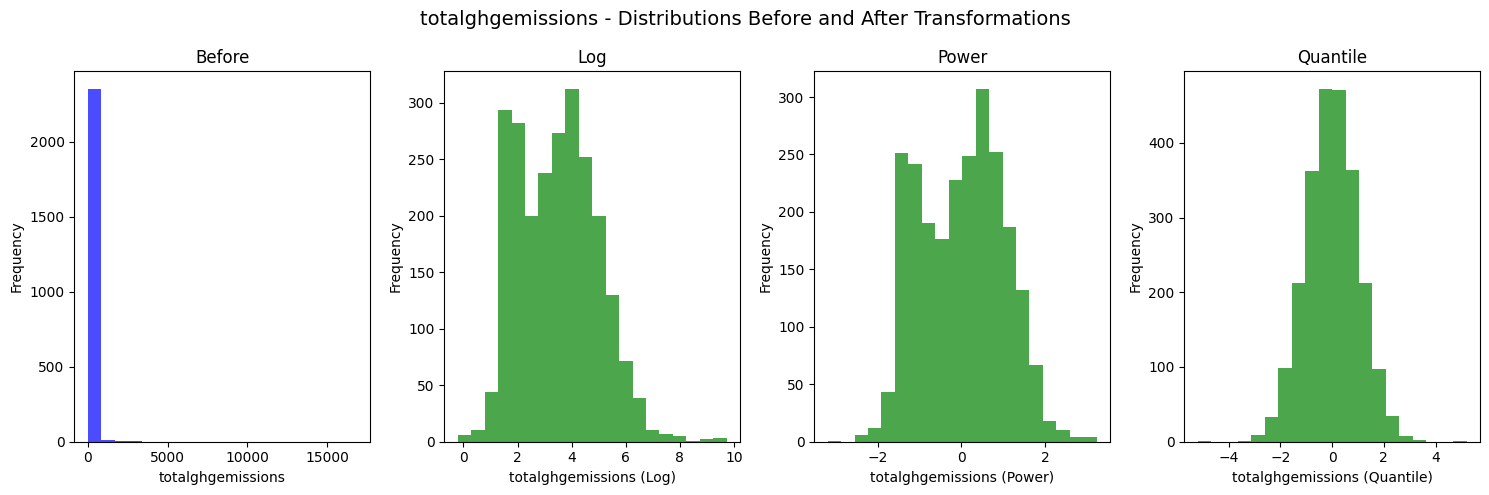

In [ ]:
# Define the transformations to apply
transformations = [('Log', np.log), ('Power', PowerTransformer()), ('Quantile', QuantileTransformer(output_distribution='normal', random_state=42))]

# Loop through the dataframe and transformations
for column in y.columns:
    variable = y[column]

    # Create subplots
    fig, axes = plt.subplots(1, len(transformations) + 1, figsize=(15, 5))
    fig.suptitle(f'{column} - Distributions Before and After Transformations', fontsize=14)

    # Plot the distribution before the transformation
    axes[0].hist(variable, bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Before')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # Apply and plot each transformation
    for i, (trans_name, trans_func) in enumerate(transformations, start=1):
        if isinstance(trans_func, PowerTransformer):
            transformer = trans_func.fit(variable.values.reshape(-1, 1))
            transformed_target = transformer.transform(variable.values.reshape(-1, 1))
        elif isinstance(trans_func, QuantileTransformer):
            transformer = trans_func.fit(variable.values.reshape(-1, 1))
            transformed_target = transformer.transform(variable.values.reshape(-1, 1))
        else:
            transformed_target = trans_func(variable.values.reshape(-1, 1))

        finite_transformed_target = transformed_target[np.isfinite(transformed_target)]
        axes[i].hist(finite_transformed_target, bins=20, alpha=0.7, color='green')
        axes[i].set_title(trans_name)
        axes[i].set_xlabel(f'{column} ({trans_name})')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

#6.Création de la pipeline

Au préalable, il nous faut créer une fonction qui va définir les colonnes à traiter en fonction du type de preprocessing :

As we try different features for the model, the number of columns in X will vary. The following function will compute the list of columns for the numerical features and the remaining categorical feature ('listofallpropertyusetypes'), which will be treated separately with a count vectorizer.

In [ ]:
def get_columns(X):
  num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
  vec = ['listofallpropertyusetypes'] if 'listofallpropertyusetypes' in X.columns else []
  ord = ['energystarscore'] if 'energystarscore' in X.columns else []
  one = X.drop(vec+ord, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
  return num, vec, ord, one

In [ ]:
def chain_pipe(model, num, transfo_num, vec, transfo_vec, ord, transfo_ord, one, transfo_one):
    '''Define the chain and preparation step, then concatenate'''

    preparation = ColumnTransformer(
    transformers=[
    ('num', transfo_num, num),
    ('vec', transfo_vec, vec),
    ('ord', transfo_ord, ord),
    ('one', transfo_one, one),
    ])

    chain = RegressorChain(model, verbose=False)

    pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('chain', chain)
    ],
    verbose=False,
    # memory='/content/cache_directory' # caching doesn't work with custom Classes
    )
    return pipe

#7.Choix de la métrique d'erreur

C'est en minimisant la MAE que nous parviendrons à obtenir les meilleurs résultats possibles avec les nouveaux fichiers CSV. La RMSE nous donnera une idée de l'importance des outliers : si elle est largement supérieure à la MAE, nous essaierons d'apporter des améliorations supplémentaires.
Si on cherche à optimiser le R2 score, on peut atteindre 0.89 mais la MAE en souffre, et les courbes donnent davantage l'impression d'un overfitting qui menace clairement.

In [ ]:
scoring='neg_mean_absolute_error'
# sklearn.metrics.get_scorer_names()

##7.1 CV Score

Dans le cas de targets multiples, scikit-learn ne fournit qu'un seul CV score représentant une moyenne pour toutes les targets. A la place, nous allons calculer une Learning Curve pour le dernier estimateur de la chaîne, qui correspond à la target 'totalghgemissions'.

In [ ]:
# Evaluate the model
def evaluate_model(opt, X_train, X_test, y_train, y_test, scoring, plot):
  # Find the best parameters
  print('\nCV parameters:')
  for key, value in opt.best_params_.items():
    print("{}: {}".format(key, value))
  # Evaluate cross validation performance
#   print('\nMean CV score (all targets):', opt.best_score_.round(2)) # useless for multiple targets
  # Plot the learning curve
  if plot is True:
    print('\nComputing Cross Validation for the Learning Curve...\n')
    # Create a pipe that will include the preparation step
    curve_pipe = Pipeline(steps=[
            ('preparation', opt.best_estimator_.regressor['preparation']),
            ('last estimator', opt.best_estimator_.regressor['chain'].base_estimator)
            ],
             verbose=False
            # memory='/content/cache_directory' # caching doesn't work with custom Classes
            )
    display = LearningCurveDisplay.from_estimator(
    curve_pipe,
    pd.concat([X_train, X_test]),
    pd.concat([y_train, y_test]),
    train_sizes=np.linspace(0.1, 1.0, num=3),
    cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    score_type="both",  # both train and test errors
    scoring=scoring,
    negate_score=True,
    score_name='Score for All Targets',
    std_display_style="fill_between",
    n_jobs=-1
    )
    _ = display.ax_.set_title('Learning Curve for the Base Estimator')

##7.2 Test Score

In [ ]:
def get_predictions(opt, X_test, y_test, targets, plot, filter):
  # Get predictions
  y_pred = opt.predict(X_test)
  y_test = y_test.to_numpy()
  # Plot the errors
  if plot is True:
    disp = PredictionErrorDisplay.from_predictions(y_test[:, 7], y_pred[:, 7], kind='actual_vs_predicted')
    plt.show()
    disp = PredictionErrorDisplay.from_predictions(y_test[:, 7], y_pred[:, 7], kind='residual_vs_predicted')
    plt.show()
  if filter is True:
    mae = mean_absolute_error(y_test[:, 7], y_pred[:, 7])
    print(f'\nMAE: {round(mae, 2):.2f}')
  else:
    # calculate MAE, RMSE and R2 score for each target
    for t, target in enumerate(targets):
        mae = mean_absolute_error(y_test[:, t], y_pred[:, t])
        rmse = np.sqrt(mean_squared_error(y_test[:, t], y_pred[:, t]))
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        print('\n' + target)
        print(f'MAE: {round(mae, 2):.2f}')
        print(f'RMSE: {round(rmse, 2):.2f}')
        print(f'R2 score: {round(r2, 4):.4f}')
  return mae

#8.Recherche des hyperparamètres

##8.1Search Space

In [ ]:
# XGBoost
xg = {
    'regressor__preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__preparation__one__onehot__min_frequency': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__chain__base_estimator__n_estimators': Categorical([i for i in range(100, 1001, 50)]),
    'regressor__chain__base_estimator__max_depth': Integer(2, 20),
    'regressor__chain__base_estimator__learning_rate': Real(1e-5, 1.0, prior='log-uniform'),
    'regressor__chain__base_estimator__subsample': Real(0.1, 1.0, prior='uniform'),
    'regressor__chain__base_estimator__colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'regressor__chain__base_estimator__colsample_bylevel': Real(0.1, 1.0, prior='uniform'),
    'regressor__chain__base_estimator__colsample_bynode': Real(0.1, 1.0, prior='uniform'),
    'regressor__chain__base_estimator__reg_alpha': Real(1e-5, 100, prior='log-uniform'),
    'regressor__chain__base_estimator__reg_lambda': Real(1e-5, 100, prior='log-uniform'),
    'regressor__chain__base_estimator__grow_policy': Categorical(['depthwise', 'lossguide']),
    'regressor__chain__base_estimator__max_bin': Categorical([i for i in range(256, 2049, 256)]),
}

##8.2 Outer Function

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def find_hyperparameters(model, search_space, X_train, X_test, y_train, y_test,
                         transfo_num, transfo_vec, transfo_ord, transfo_one,
                         scoring=scoring, targets=targets,
                         *, plot=False, save=False, filter=False):
  '''print scores and return the feature importances if needed'''

  # Get the columns corresponding to the current selection of features
  num, vec, ord, one = get_columns(X_train)
  # create the pipeline
  features_pipe = chain_pipe(model, num, transfo_num, vec, transfo_vec, ord, transfo_ord, one, transfo_one)
  pipe = TransformedTargetRegressor(regressor=features_pipe,
                                    transformer=PowerTransformer())
  # use BayesSearchCV to find optimal hyperparameters
  opt = BayesSearchCV(
    pipe,
    search_space,
    n_iter=1,
    scoring=scoring,
    cv=2,
    n_jobs=-1,
    n_points=10,
    verbose=0,
    error_score='raise',
    random_state=42
    )
  opt.fit(X_train, y_train)
  if filter is False:
      # get best parameters
      evaluate_model(opt, X_train, X_test, y_train, y_test, scoring, plot)
  # get predictions
  score = get_predictions(opt, X_test, y_test, targets, plot, filter)
  # plot learning curve
  # Save the best model to a file
  if save is True:
    file_name = f"{str(model).split('(')[0]}_{len(X_train.columns)}features_{X_train.shape[0]}rows_{round(score, 2):.2f}.joblib"
    dump((opt, score), file_name)
  return opt, score

##8.1 Test

In [ ]:
import math

num_features = 5
total_combinations = sum(math.comb(num_features, k) for k in range(1, num_features + 1))

print(f"Total number of combinations: {total_combinations}")

Total number of combinations: 31


In [ ]:
from sklearn.pipeline import Pipeline

# Create your pipeline
pipeline = Pipeline([
    ('step1', transfo_num),
    ('step2', transfo_vec),
    ('step3', transfo_ord),
    ('step4', transfo_one)
])

# Get the list of transformers
transformers = [step[1] for step in pipeline.steps]

print(transformers)

[Pipeline(steps=[('scaling', PowerTransformer())]), Pipeline(steps=[('imputation1', SimpleImputer(strategy='most_frequent')),
                ('converter', ArrayToStringTransformer()),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function tok at 0x7d48bbede950>))]), Pipeline(steps=[('ordinal',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('imputation', SimpleImputer(strategy='most_frequent')),
                ('scaling', PowerTransformer())]), Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                               sparse_output=False))])]


In [ ]:
# Check null values
num, vec, ord, one = get_columns(X)
unknown = {}
for t, type in enumerate([num, vec, ord, one]):
    print(f'{type}\nInput:\n{X[type].isna().sum()}')
    transfo_type = [transfo_num, transfo_vec, transfo_ord, transfo_one][t]
    output = transfo_type.fit_transform(X[type])
    if isinstance(output, np.ndarray) and np.issubdtype(output.dtype, np.number):
        null_count = np.isnan(output).sum()
    elif isinstance(output, pd.DataFrame) or isinstance(output, pd.Series):
        null_count = output.isna().sum().sum()
    elif issparse(output):
        null_count = np.isnan(output.toarray()).sum()
    else:
        unknown[type] = output
    print(f'Output: {null_count}\n')

print(f'Unknown output: {len(unknown)}')
if len(unknown) != 0:
    print(f'\n{unknown}')

['numberofbuildings', 'numberoffloors', 'propertygfatotal', 'propertygfaparking', 'age']
Input:
numberofbuildings     0
numberoffloors        0
propertygfatotal      0
propertygfaparking    0
age                   0
dtype: int64
Output: 0

['listofallpropertyusetypes']
Input:
listofallpropertyusetypes    0
dtype: int64
Output: 0

['energystarscore']
Input:
energystarscore    0
dtype: int64
Output: 0

['primarypropertytype', 'councildistrictcode', 'largestpropertyusetype', 'steam', 'naturalgas']
Input:
primarypropertytype       0
councildistrictcode       0
largestpropertyusetype    0
steam                     0
naturalgas                0
dtype: int64
Output: 0

Unknown output: 0


In [ ]:
# Check null values
num, vec, ord, one = get_columns(X)

for t, type in enumerate([num, vec, ord, one]):
    print(f'{type}\ninput: {X[type].isna().sum()}')
    transfo_type = [transfo_num, transfo_vec, transfo_ord, transfo_one][t]
    output = transfo_type.fit_transform(X[type])

    if isinstance(output, np.ndarray) and np.issubdtype(output.dtype, np.number):
        null_count = np.isnan(output).sum()
    elif isinstance(output, pd.DataFrame) or isinstance(output, pd.Series):
        null_count = output.isna().sum().sum()
    else:
        # null_count = 0
        pb, problematic = type, output
    print(f'{type} output: {null_count}\n')
print(f'this type is problematic: {pb}\n{problematic}')

['numberofbuildings', 'numberoffloors', 'propertygfatotal', 'propertygfaparking', 'age']
input: numberofbuildings     0
numberoffloors        0
propertygfatotal      0
propertygfaparking    0
age                   0
dtype: int64
['numberofbuildings', 'numberoffloors', 'propertygfatotal', 'propertygfaparking', 'age'] output: 0

['listofallpropertyusetypes']
input: listofallpropertyusetypes    0
dtype: int64
['listofallpropertyusetypes'] output: 0

['energystarscore']
input: energystarscore    0
dtype: int64
['energystarscore'] output: 0

['primarypropertytype', 'councildistrictcode', 'largestpropertyusetype', 'steam', 'naturalgas']
input: primarypropertytype       0
councildistrictcode       0
largestpropertyusetype    0
steam                     0
naturalgas                0
dtype: int64
['primarypropertytype', 'councildistrictcode', 'largestpropertyusetype', 'steam', 'naturalgas'] output: 0

this type is problematic: ['listofallpropertyusetypes']
  (0, 17)	1
  (1, 17)	1
  (1, 38)	1
  

In [ ]:
# features_pipe = chain_pipe(DummyRegressor(), num, transfo_num, vec, transfo_vec, ord, transfo_ord, one, transfo_one)
# pipe = TransformedTargetRegressor(regressor=features_pipe,
#                                     transformer=PowerTransformer())
# pipe.get_params()

In [ ]:
# dr = {
#     # 'regressor__preparation__geo__clustering__kw_args': {'n_clusters': 2},
#     'regressor__chain__base_estimator__quantile' : [0.5]
# }
# opt, score = find_hyperparameters(DummyRegressor(), dr, X_train, X_test, y_train, y_test,
#                                   transfo_num, transfo_vec, transfo_ord, transfo_one,
#                                   plot=False)
# opt

In [ ]:
# Stop "Run all/after" from going beyond this cell
# assert False

##8.2Full Fit

###8.2.1 GPU

In [ ]:
# opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='gradient_based', tree_method='gpu_hist', missing=-999), xg, X, y,
#                                   transfo_num, transfo_vec, transfo_ord, transfo_one,
#                                   plot=True, save=True)

###8.2.2 CPU


CV parameters:
regressor__chain__base_estimator__colsample_bylevel: 0.46909356296798244
regressor__chain__base_estimator__colsample_bynode: 0.7549531688595925
regressor__chain__base_estimator__colsample_bytree: 0.9395811989630505
regressor__chain__base_estimator__grow_policy: depthwise
regressor__chain__base_estimator__learning_rate: 0.022425376406560126
regressor__chain__base_estimator__max_bin: 1024
regressor__chain__base_estimator__max_depth: 8
regressor__chain__base_estimator__n_estimators: 750
regressor__chain__base_estimator__reg_alpha: 0.0013528298497308454
regressor__chain__base_estimator__reg_lambda: 0.34240580462132914
regressor__chain__base_estimator__subsample: 0.5949675476288058
regressor__preparation__one__onehot__min_frequency: 3.9444668286902315e-05
regressor__preparation__vec__vectorizer__min_df: 6.867694861739219e-05

Computing Cross Validation for the Learning Curve...



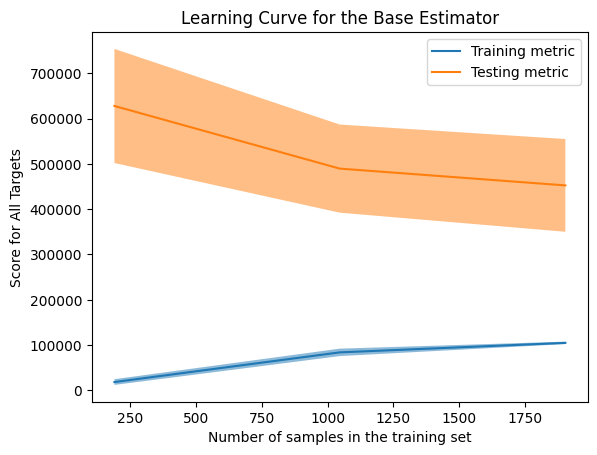

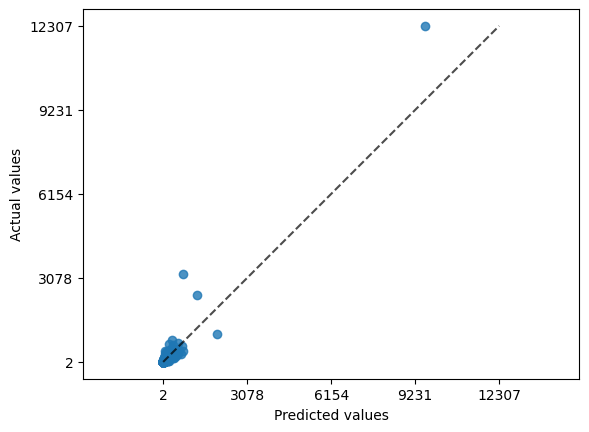

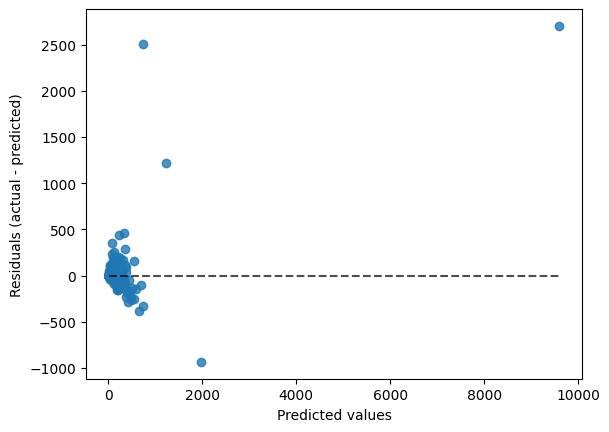


sourceeuiwn_kbtu_sf
MAE: 21.08
RMSE: 36.78
R2 score: 0.8808

source_wn
MAE: 0.02
RMSE: 0.03
R2 score: 0.4514

siteeuiwn_kbtu_sf
MAE: 10.18
RMSE: 17.61
R2 score: 0.8557

site_wn
MAE: 0.02
RMSE: 0.03
R2 score: 0.4381

source_site
MAE: 0.21
RMSE: 0.33
R2 score: 0.6876

siteenergyusewn_kbtu
MAE: 1397541.41
RMSE: 4956992.47
R2 score: 0.9017

siteenergyuse_kbtu
MAE: 1450038.39
RMSE: 6114366.48
R2 score: 0.8459

totalghgemissions
MAE: 48.50
RMSE: 195.83
R2 score: 0.8936


In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True, save=False)

La MAE et le R2 score se sont améliorés, mais la RMSE et sa forte sensibilité aux outliers nous indique qu'il faut essayer de progresser de ce côté.

8.2.3 Visualisation de la pipeline

In [ ]:
opt

BayesSearchCV(cv=2,
              estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preparation',
                                                                              ColumnTransformer(transformers=[('num',
                                                                                                               Pipeline(steps=[('scaling',
                                                                                                                                PowerTransformer())]),
                                                                                                               ['numberofbuildings',
                                                                                                                'numberoffloors',
                                                                                                                'propertygfatotal',
                                                                                                                'propertygfaparking',
                                                                                                                'age']),
                                                                                                              ('vec',
                                                                                                               Pipeline(steps=[('imputation1',
                                                                                                                                SimpleImputer(strategy='most_frequent')),...
                             'regressor__chain__base_estimator__reg_lambda': Real(low=1e-05, high=100, prior='log-uniform', transform='normalize'),
                             'regressor__chain__base_estimator__subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'regressor__preparation__one__onehot__min_frequency': Real(low=1e-05, high=0.5, prior='log-uniform', transform='normalize'),
                             'regressor__preparation__vec__vectorizer__min_df': Real(low=1e-05, high=0.5, prior='log-uniform', transform='normalize')})

In [ ]:
# Stop "Run all/after" from going beyond this cell
assert False

AssertionError: ignored

#9.Sélection des Features

RFECV

##9.1 Feature Importances

Pour l'instant, TransformedTargetRegressor ne fournit pas l'attribut feature_importances_ concernant le dernier estimateur du ChainRegressor. Le preprocessing manuel des targets (.tests/targets_manual_preprocessing.ipynb) permet d'aboutir aux résultats suivants :

In [ ]:
# Retrieve the dictionary from targets_manual_preprocessing.ipynb (and the saved opt if necessary)
feature_importances = load('feature_importances.joblib')
# file_name = 'XGBRegressor_12features_1903rows_50.13.joblib'
# opt, score = load(file_name)

In [ ]:
# Sort the feature importances by value in descending order
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_importances

In [ ]:
# Extract the feature names and importances in separate lists
features = [x[0] for x in sorted_importances]
importances = [x[1] for x in sorted_importances]
import plotly.express as px

# Create a bar plot of the feature importances
fig = px.bar(x=features, y=importances)
fig.update_layout(xaxis_tickangle=-90, xaxis_title='Feature', yaxis_title='Importance', title='Feature Importances', height=1000)
fig.show()

##9.2 Backward Selection


Le gaz EDA?
La régularisation L1 semble avoir bien discriminé les features. Comme l'EDA pouvait l'indiquer, l'âge des bâtiments et l'EnergyStar score n'apportent pas grand-chose. Il est possible que nous n'ayons même plus besoin de ces features. La backward selection va nous permettre de calculer l'impact de leur suppression sur la performance du modèle. Puisque les émissions se mesurent en tonnes, nous allons arrêter l'algorithme dès que la MAE s'accroît de deux tonnes parce que c'est déjà beaucoup pour un bâtiment.

In [ ]:
score_curve = [score]
selection_score = {}
stop_count = 0
for f, feature in enumerate(reversed(features[1:])):
    features.remove(feature)
    print(f'Removed Feature: {feature}')
    X_train_sel = X_train[features]
    X_test_sel = X_test[features]
    # opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='gradient_based', tree_method='gpu_hist', missing=-999), xg, X_train_sel, X_test_sel, y_train, y_test,
    #                                   transfo_num, transfo_vec, transfo_ord, transfo_one)
    opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train_sel, X_test_sel, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  filter=True)
    score_curve.append(score)
    selection_score[score] = features.copy()
    f += 1
    print('\n')
    # Check the score curve for early stopping
    # If the new score increases substantially from the previous one
    if score_curve[-1] > score_curve[-2] + 1:
        stop_count += 1
    else:
        stop_count = 0
    # If the score has increased for 3 consecutive iterations, stop the loop
    if stop_count == 3:
        print('Early stopping due to prolonged increase.')
        break

La MAE s'améliore quand on supprime les features 'energystarscore', 'numberofbuildings', 'numberoffloors' et 'listofallpropertyusetypes' du set global, ce qui amène à tenter d'autres combinaisons. Par exemple :

In [ ]:
X_train_sel = X_train.drop(['energystarscore', 'numberofbuildings'], axis=1)
X_test_sel = X_test.drop(['energystarscore', 'numberofbuildings'], axis=1)

In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train_sel, X_test_sel, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  filter=True)

In [ ]:
X_train_sel = X_train.drop(['numberoffloors', 'listofallpropertyusetypes'], axis=1)
X_test_sel = X_test.drop(['numberoffloors', 'listofallpropertyusetypes'], axis=1)

In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train_sel, X_test_sel, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  filter=True)

In [ ]:
X_train_sel = X_train.drop(['energystarscore', 'numberoffloors'], axis=1)
X_test_sel = X_test.drop(['energystarscore', 'numberoffloors'], axis=1)

In [ ]:
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train_sel, X_test_sel, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  filter=True)

Bingo !

Nous allons pouvoir alléger X_train et X_test pour la suite des opérations, ce qui nous fera gagner un peu de temps. Si un autre modèle s'avère plus performant que XGBoost, nous ferons un nouveau test.


CV parameters:
regressor__chain__base_estimator__colsample_bylevel: 0.46909356296798244
regressor__chain__base_estimator__colsample_bynode: 0.7549531688595925
regressor__chain__base_estimator__colsample_bytree: 0.9395811989630505
regressor__chain__base_estimator__grow_policy: depthwise
regressor__chain__base_estimator__learning_rate: 0.022425376406560126
regressor__chain__base_estimator__max_bin: 1024
regressor__chain__base_estimator__max_depth: 8
regressor__chain__base_estimator__n_estimators: 750
regressor__chain__base_estimator__reg_alpha: 0.0013528298497308454
regressor__chain__base_estimator__reg_lambda: 0.34240580462132914
regressor__chain__base_estimator__subsample: 0.5949675476288058
regressor__preparation__one__onehot__min_frequency: 3.9444668286902315e-05
regressor__preparation__vec__vectorizer__min_df: 6.867694861739219e-05

Computing Cross Validation for the Learning Curve...



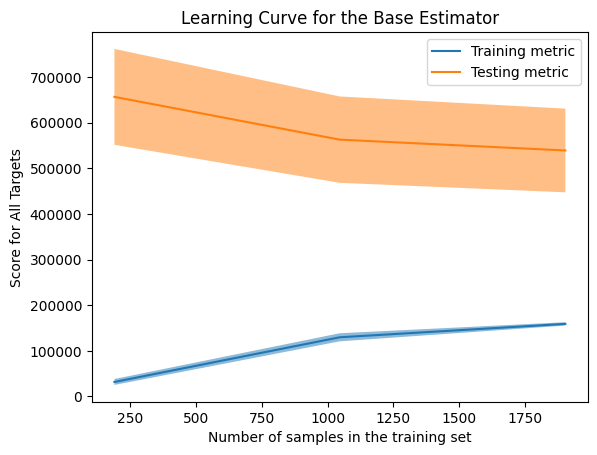

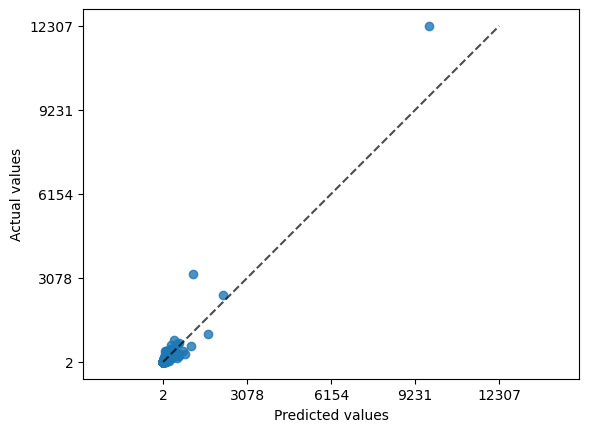

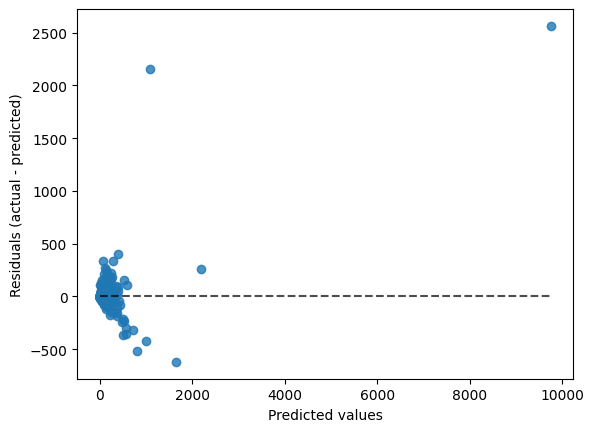


sourceeuiwn_kbtu_sf
MAE: 36.49
RMSE: 66.53
R2 score: 0.6102

source_wn
MAE: 0.02
RMSE: 0.03
R2 score: 0.3972

siteeuiwn_kbtu_sf
MAE: 15.60
RMSE: 27.09
R2 score: 0.6586

site_wn
MAE: 0.02
RMSE: 0.03
R2 score: 0.4023

source_site
MAE: 0.21
RMSE: 0.33
R2 score: 0.6862

siteenergyusewn_kbtu
MAE: 1639541.69
RMSE: 4741695.22
R2 score: 0.9101

siteenergyuse_kbtu
MAE: 1650559.83
RMSE: 4895577.59
R2 score: 0.9012

totalghgemissions
MAE: 47.17
RMSE: 173.47
R2 score: 0.9165


In [ ]:
X_train.drop(['energystarscore', 'numberoffloors'], axis=1, inplace=True)
X_test.drop(['energystarscore', 'numberoffloors'], axis=1, inplace=True)
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True, save=False)

In [ ]:
# Stop "Run all/after" from going beyond this cell
assert False

#10.Comparaison des modèles

##10.1MLPRegressor

In [ ]:
mlp = {
    'regressor__preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__preparation__one__onehot__min_frequency': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__chain__base_estimator__activation': Categorical(['relu', 'logistic', 'tanh']),
    'regressor__chain__base_estimator__solver': Categorical(['adam', 'lbfgs']),
    'regressor__chain__base_estimator__alpha': Real(1e-5, 1.0, prior='log-uniform'),
    'regressor__chain__base_estimator__learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
    'regressor__chain__base_estimator__learning_rate_init': Real(1e-5, 1.0, prior='log-uniform'),
    'regressor__chain__base_estimator__max_iter': Integer(200, 1000)
}

In [ ]:
opt, score = find_hyperparameters(MLPRegressor(early_stopping=True), mlp, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True, save=True)

##10.xKernelRidge

In [ ]:
krr = {
    'regressor__preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__preparation__one__onehot__min_frequency': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__chain__base_estimator__alpha': Real(1e-5, 1.0, prior='log-uniform'),
    'regressor__chain__base_estimator__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'regressor__chain__base_estimator__gamma': Real(1e-5, 1.0, prior='log-uniform'),
    'regressor__chain__base_estimator__degree': Integer(1, 5),
    'regressor__chain__base_estimator__coef0': Real(0.0, 1.0),
}

In [ ]:
opt, score = find_hyperparameters(KernelRidge(), krr, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True, save=True)

##10.2HistGradientBoostingRegressor

In [ ]:
hgb = {
    'regressor__preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__preparation__one__onehot__min_frequency': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__chain__base_estimator__loss': Categorical(['squared_error', 'absolute_error']),
    'regressor__chain__base_estimator__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'regressor__chain__base_estimator__max_iter': Categorical([i for i in range(100, 1001, 50)]),
    'regressor__chain__base_estimator__max_leaf_nodes': Integer(2, 500),
    'regressor__chain__base_estimator__min_samples_leaf': Integer(1, 50),
    'regressor__chain__base_estimator__l2_regularization': Real(1e-10, 1e-1, prior='log-uniform')
}

In [ ]:
opt, score = find_hyperparameters(HistGradientBoostingRegressor(), hgb, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True, save=True)

##10.1 RandomForestRegressor

In [ ]:
# define the search space for hyperparameters
n_features = X.shape[1]
rf = {
    'regressor__preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__preparation__one__onehot__min_frequency': Real(1e-5, 0.5, prior='log-uniform'),
    'regressor__chain__base_estimator__n_estimators': Categorical([i for i in range(100, 1001, 50)]),
    'regressor__chain__base_estimator__max_depth': Integer(2, 20),
    'regressor__chain__base_estimator__min_samples_split': Integer(2, 10),
    'regressor__chain__base_estimator__min_samples_leaf': Integer(1, 10),
    'regressor__chain__base_estimator__max_features': Integer(int(np.log2(n_features)), n_features),
    'regressor__chain__base_estimator__max_samples': Real(0.1, 1.0, prior='log-uniform')
}

In [ ]:
opt, score = find_hyperparameters(RandomForestRegressor(), rf, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True, save=True)

Tous ces modèles font moins bien que XGBoost, mais leur aggrégation pourra permettre d'améliorer le score quand scikit-learn et seront capables de gérer les targets multiples.

#13Détection des Outliers

Jusqu'à présent, nous avons essayé de procéder sagement, mais il est temps de prendre des risques et tenter des expérimentations. Le dataset étant très petit, nous allons utiliser quasiment toutes les données pour le train set qui servira à filtrer les outliers. Le test set aura une taille corresopndant au minimum fixé par les dévelopeurs >50 (75 ici pour un ratio de 0.03). Si les résultats sont porteurs d'espoirs, nous ferons ensuite des vérifications avec les données de l'année

Après avoir expérimenté, il s'avère qu'il vaut mieux adopter une approche conservative : les outliers ne seront supprimés que si la MAE s'améliore d'au moins une tonne.

In [ ]:
X_train.drop(['energystarscore', 'numberoffloors'], axis=1, inplace=True)
X_test.drop(['energystarscore', 'numberoffloors'], axis=1, inplace=True)

In [ ]:
def get_outliers(X_train, y_train, transfo_num, transfo_vec, transfo_ord, transfo_one, quantile=0.05):
    num, vec, ord, one = get_columns(X_train)
    preparation = ColumnTransformer(
    transformers=[
    ('num', transfo_num, num),
    ('vec', transfo_vec, vec),
    ('ord', transfo_ord, ord),
    ('one', transfo_one, one),
    ])
    lof_pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('detection', LocalOutlierFactor())
    ],
    verbose=True,
    # memory='/content/cache_directory' # caching doesn't work with custom Classes
    )
    df_filt = pd.concat([X_train, y_train], axis=1)
    df_lof = df_filt.drop(['sourceeuiwn_kbtu_sf', 'source_wn', 'siteeuiwn_kbtu_sf', 'site_wn', 'source_site', 'siteenergyusewn_kbtu'], axis=1)
    lof_pipe.fit(df_lof)
    anomaly_scores = lof_pipe['detection'].negative_outlier_factor_
    threshold = np.quantile(anomaly_scores, quantile)
    outliers = df_filt[anomaly_scores < threshold].index.tolist()
    print(f'\n\n{len(outliers)} outliers for quantile={quantile}\n')
    return outliers, quantile

In [ ]:
def remove_outliers(X_train, X_test, y_train, y_test, transfo_num, transfo_vec, transfo_ord, transfo_one, targets=targets, *, save=False):
    outliers, quantile = get_outliers(X_train, y_train, transfo_num, transfo_vec, transfo_ord, transfo_one)
    outliers_to_remove = []

    # Instantiate the MAE score prior to removing outliers
    opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_train, X_test, y_train, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  filter=True)
    unfiltered_mae = score

    for o, outlier in enumerate(outliers, 1):
        print(f'\n\n\nSTEP {o} OUT OF {len(outliers)}:')
        # find the best hyperparameters for the filtered set
        X_filt = X_train.drop(outlier)
        y_filt = y_train.drop(outlier)
        opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_filt, X_test, y_filt, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  filter=True)
        print(f'\nIndex: {outlier}')
        if score < unfiltered_mae - 1: # empirical
            outliers_to_remove.append(outlier)
            print('Outlier to remove.')
        else:
            print('Outlier to keep.')
    print(f'\n\n\n\n{len(outliers_to_remove)} outliers to remove:\n{outliers_to_remove}')
    if save is True:
        dump(outliers_to_remove, f'outliers_{quantile}quantile.joblib')
    return outliers_to_remove

In [ ]:
outliers_to_remove = remove_outliers(X_train, X_test, y_train, y_test, transfo_num, transfo_vec, transfo_ord, transfo_one, save=True)

In [ ]:
# Load saved outliers if necessary
# outliers_to_remove = load('outliers_0.01quantile.joblib')

In [ ]:
X_filt = X_train.drop(outliers_to_remove)
y_filt = y_train.drop(outliers_to_remove)
opt, score = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_filt, X_test, y_filt, y_test,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one,
                                  plot=True)

In [ ]:
# Stop "Run all/after" from going beyond this cell
assert False

Comme nous pouvons le voir, il reste des outliers récalcitrants, que nous pourrions tenter de supprimer manuellement.
Pour l'instant, nous allons en rester là et conserver le PowerTransformer pour le preprocessing.
Si le temps le permet
L'autre amélioration possible serait d'utiliser

Nous opurrions aussi refaire la même démarche en plaçant la consommation énergétique en dernier pour booster son score.

In [ ]:
# Create a DataFrame for the scores
scores_df = pd.DataFrame(test_scores).T
scores_df.columns = ['MAE', 'RMSE', 'R2']
scores_df['Outliers Removed'] = outliers_removed

# Plot the score curves
fig = px.line(scores_df, x='Outliers Removed', y=['MAE', 'RMSE', 'R2'],
              labels={'Outliers Removed': 'Number of Outliers Removed', 'value': 'Score'},
              title='Scores vs. Number of Outliers Removed')
fig.show()

In [ ]:
sorted_thresholds = sorted(threshold_scores.items(), key=lambda x: x[1], reverse=True)
sorted_thresholds

In [ ]:
score_curve = [score]
threshold_score = {}
stop_count = 0
for threshold in range(1, 14):
    threshold = -1 - threshold / 10
    df_filtered = df_filt[anomaly_scores > threshold]
    print(f'Size of the filtered set: {df_filtered.shape[0]}\n\n')
    y_filtered = df_filtered[targets]
    X_filtered = df_filtered.drop(targets, axis=1)
    # find the best hyperparameters for the filtered set
    opt, _ = find_hyperparameters(xgb.XGBRegressor(sampling_method='uniform', tree_method='hist', missing=-999), xg, X_filtered, y_filtered,
                                  transfo_num, transfo_vec, transfo_ord, transfo_one)
    # get predictions for the unfiltered set
    score = get_predictions(opt, X_test, y_test)
    score_curve.append(score)
    threshold_score[score] = threshold
    print('\nTHRESHOLD {} score: {}\n\n\n\n'.format(threshold, score))
    # Check the score curve for early stopping
    # If the new score increases substantially from the previous one
    if score_curve[-1] > score_curve[-2] + 1:
        stop_count += 1
    # If the total increase reaches 10, stop the loop
    if stop_count == 10:
        print('Early stopping due to substantial score increase.')
        break

In [ ]:
# Create a DataFrame with anomaly scores
anomaly_data = pd.DataFrame({'Anomaly Scores': anomaly_scores})

# Plot density plot
fig = px.scatter(anomaly_data, y='Anomaly Scores')
fig.update_layout(title='Density Plot of Anomaly Scores', xaxis_title='Samples', yaxis_title='Anomaly Scores')

fig.show()

In [ ]:
# List of outlier indexes
outlier_indexes = [17, 268, 370, 1476, 1660, 1912, 2041]  # Replace with your own list of outlier indexes

# Filter the DataFrame based on the outlier indexes
df_outliers1 = df.iloc[outlier_indexes]

# Filter the DataFrame based on the outlier indexes using the values of the indexes
df_outliers2 = df[df.index.isin(outlier_indexes)]

# Display the filtered DataFrame in the same format as df.head()
df_outliers1

In [ ]:
# TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#11.Export du modèle choisi

In [ ]:
# Select the best hyperparameters
best_pipe = opt.best_estimator_
# Fit the pipeline on the original dataset
X = df.drop(targets, axis=1)
best_pipe.fit(X, y)
# Save the resulting model to a file
dump(best_pipe, 'xgboost_model.joblib')
files.download('xgboost_model.joblib')